In [1]:
import numpy as np
from scipy.stats import truncnorm, norm, binom, t
import matplotlib.pyplot as plt
import random
import math

In [2]:
cutoff = 0.95 # The European norm for the required accuracy of the machine

# Classes

In [3]:
class Wafer:
    pass

In [4]:
class SolarCell:
    def __init__(self, working):
        self.working = working

In [188]:
class Machine:
    runtime = 0  #In Minutes
    costs = 0
    
    def __init__(self, p):  #Constructor
        """Make machine with probability p of turning a wafer into a working cell."""
        self.p = p
    
    def deposit(self, wafer):
        """Deposit a Wafer, returns a SolarCell"""
        self.runtime += 9    #9 minutes per deposition per wafer
        self.costs += 2 + 87/35  #It costs €2 to do a deposition. Wafers have a base cost of €87, but can be re-used 35 times
        working = random.random() < self.p 
        
        return SolarCell(working)
    
    def diagnosis(self, cell):
        """Diagnose a SolarCell, returns whether the cell works"""
        self.runtime += 2 if cell.working else 3  # Diagnosis costs 2 minutes if the created cell works, 3 minutes otherwise
        return cell.working
    
    def test_basic(self, n):
        """Test the machine n times and return the ratio of working cells"""
        wafers = n * [Wafer()] # Create list of n Wafer() objects
        cells = list(map(self.deposit, wafers)) # Deposit all wafers
        working_cells = list(filter(self.diagnosis, cells)) # Make list of working cells
        return len(working_cells)/len(cells) # Determine ratio of the amount of working cells and total cells 
    
    def get_stats(self):
        """Pretty print the status of machine."""
        days = self.runtime // (24 * 60)
        hours = (self.runtime % (24 * 60)) // 60
        minutes = (self.runtime % (24 * 60)) % 60
        rcosts = round(self.costs, 2)
        
        print("Actual accuracy of machine:", self.p)
        print("It takes", days, "day(s),", hours, "hour(s) and", minutes, "minute(s) to test.")
        print("The costs associated with this test method is €" + str(rcosts))
        
    def reset(self):
        """Reset the machine."""
        self.runtime = 0
        self.costs = 0
        
    def plot_pmf(self, n):
        """Plot the probability of each estimation of p resulting from n tests."""
        fig, ax = plt.subplots(1, 1)
        x = np.arange(binom.ppf(0.001, n, self.p), n+1)
        ax.plot(x/n, binom.pmf(x, n, self.p), 'bo', ms=8, label='binom pmf')
        ax.vlines(x/n, 0, binom.pmf(x, n, self.p), colors='b', lw=5, alpha=0.5)
        ax.axvline(x = self.p, color='g')
        ax.set_xlabel("estimated p")
        ax.set_ylabel("probability")
        plt.show()
        
    def plot_cdf(self, n):
        """Plot cdf of estimation of p resulting from n tests."""
        fig, ax = plt.subplots(1, 1)
        x = np.arange(binom.ppf(0.001, n, self.p), n+1)
        ax.plot(x/n, binom.cdf(x, n, self.p), 'bo', ms=8, label='binom pmf')
        ax.vlines(x/n, 0, binom.cdf(x, n, self.p), colors='b', lw=5, alpha=0.5)
        ax.axvline(x = self.p, color='g')
        ax.set_xlabel("estimated p")
        ax.set_ylabel("cumulative density function")
        plt.show()

    # Testing with variable number of tests
    def test_advanced_95(self, min_tests, max_tests):
        """Test the machine until it is 95% certain that the machine works or we reached the maximum number of tests.
        Maximum number of tests is given by max_tests.
        """
        successes = 0
        p_ = 1
        #min_tests = 50
        
        if max_tests < min_tests:
            min_tests = max_tests

        for n in range(1, min_tests):
            if self.diagnosis(self.deposit(Wafer())):
                successes += 1
            p_ = successes / n
        
        for n in range(min_tests + 1, max_tests + 1):
            if self.diagnosis(self.deposit(Wafer())):
                successes += 1
            p_ = successes / n
            
            (left, right) = Machine.wilson_score_interval_95(p_, n)
            
            if (left > cutoff and right > cutoff):
                return (p_, n, True) # true means that a definitive answer was reached
            
            if (left < cutoff and right < cutoff):
                return (p_, n, True)
                   
        return (p_, n, False) # false means that the maximum number of tests was reached before reaching a definitive answer
    
    def calculate_interval(certainty, p_, n):
        """Incorrect implementation, use wilson_score_interval_95 instead"""
        error = (1 - certainty) / 2
        
        # Bounds expressed in successes
        leftS = binom.ppf(error, n, p_)
        rightS = binom.ppf(1 - error, n, p_)
        
        # Express in p_
        return (leftS / n, rightS / n)

    
    def wilson_score_interval_95(p_, n):
        """Returns (the Wilson approximation of) the interval such that it is 95% certain that after n tests
        the actual probability of the machine lies in this interval"""
        # From https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval
        z = 1.96 # 1.96 for 95% confidence, 2.576 for 99%
        
        base = (p_ + z**2/(2*n))/(1+z**2/n)
        spread = z/(1+z**2/n) * math.sqrt((p_*(1-p_))/n + z**2/(4*n**2))
        
        left = base - spread
        right = base + spread
        
        return (left, right)
        
    def procedure_basic(self, n):
        """This basic procedure uses the test_basic to approximate the accuracy of the machine.
        The basic test takes n wafers and returns the ratio (=p_) of working wafers"""
        return self.test_basic(n) >= cutoff
    
    def procedure_advanced_95(self, min_tests, max_tests):
        """This procedure uses test_advanced to approximate the accuracy of the machine."""
        (p_, n, state) = self.test_advanced_95(min_tests, max_tests)
        return p_ >= cutoff
    
    def procedure_advanced_95_true(self, min_tests, max_tests):
        """This procedure uses test_advanced to approximate the accuracy of the machine."""
        (p_, n, state) = self.test_advanced_95(min_tests, max_tests)
        if state == True:
            return p_ >= cutoff
        else: return True
        
    def procedure_advanced_95_false(self, min_tests, max_tests):
        """This procedure uses test_advanced to approximate the accuracy of the machine."""
        (p_, n, state) = self.test_advanced_95(min_tests, max_tests)
        if state == True:
            return p_ >= cutoff
        else: return False
    
    def procedure_trivial(self):
        # This testing procedure basically doesn't test, but accepts all machines
        # Used for cost computation purposes
        return True


In [269]:
class Factory:
    def __init__(self, mu, sigma):
        """Factory that makes a machine with accuracies normally distributed."""
        self.mu = mu
        self.sigma = sigma
        
    def makeMachine(self):
        """Make machine"""
        p = truncnorm(-self.mu / self.sigma, (1 - self.mu) / self.sigma, loc=self.mu, scale=self.sigma).rvs(1)[0]
        return Machine(p)
    
    def createBatch(self, n):
        """Makes a list containing n machines, where the distribution of p of these machines comes from the
        normal distribution of the factory."""
        batch = []
        for i in range(n):
            m = self.makeMachine()
            batch.append(m)
        return batch
    
    def test_procedure_batch(self, procedure, batch):
        """Test a procedure on machines from a list batch
        Procedure is a function that takes a machine and returns whether the machien works correctly"""
        successes = 0
        costs = 0
        time = 0
        
        for i in range(len(batch) - 1):
            if procedure(batch[i]) == (batch[i].p >= cutoff):
                successes += 1
            costs += batch[i].costs
            time  += batch[i].runtime
            batch[i].reset()
            
        costs /= len(batch)
        time /= len(batch)
        
        print(f"Testing procedure was accurate {successes/len(batch)*100}% of the time.")

        days = time // (24 * 60)
        hours = (time % (24 * 60)) // 60
        minutes = (time % (24 * 60)) % 60
        rcosts = round(costs, 2)

        print("Test procedure took on average ", days, "day(s),", hours, "hour(s) and", minutes, "minute(s).")
        print("The costs associated with this test procedure is on average €" + str(rcosts))
        #print("Roughly " + str(hard_machines*100) + "% of the " + str(n) + " machines made had a probability within 0.005 of 0.95.")
    
    def test_testing_procedure(self, procedure, n): #onhandige naam maarja...
        """Test a procedure on machines normally distributed with mu sigma (truncated) n times.
        Procedure is a function that takes a machine and returns whether the machine works correctly."""
        successes = 0
        costs = 0
        time = 0
        hard_machines = 0

        for i in range(n):
            m = self.makeMachine()
            if abs(m.p - 0.95) <= 0.005:
                hard_machines += 1
            # if procedure gives correct result
            if procedure(m) == (m.p >= cutoff):
                successes += 1

            costs += m.costs
            time += m.runtime
        costs /= n
        time /= n
        hard_machines /= n

        print(f"Testing procedure was accurate {successes/n*100}% of the time.")

        days = time // (24 * 60)
        hours = (time % (24 * 60)) // 60
        minutes = (time % (24 * 60)) % 60
        rcosts = round(costs, 2)

        print("Test procedure took on average ", days, "day(s),", hours, "hour(s) and", minutes, "minute(s).")
        print("The costs associated with this test procedure is on average €" + str(rcosts))
        print("Roughly " + str(hard_machines*100) + "% of the " + str(n) + " machines made had a probability within 0.005 of 0.95.")

# Playground

In [238]:
m = Machine(0.963)

In [239]:
p_ = m.test_basic(100)
print("Projected accuracy of machine:", p_)
m.get_stats()
m.reset()

Projected accuracy of machine: 0.97
Actual accuracy of machine: 0.963
It takes 0 day(s), 18 hour(s) and 23 minute(s) to test.
The costs associated with this test method is €448.57


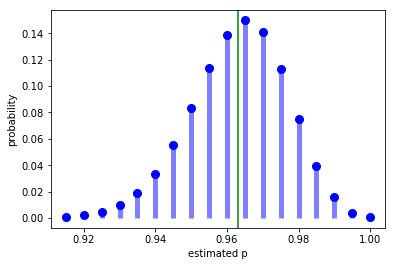

In [240]:
m.plot_pmf(200)

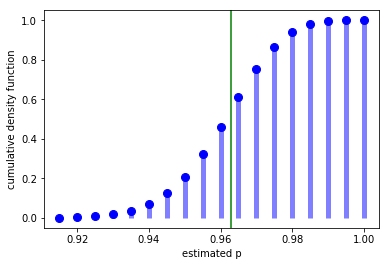

In [241]:
m.plot_cdf(200)

In [242]:
print(m.test_advanced_95(10, 27))
m.reset()

(0.9259259259259259, 27, False)


---

In [243]:
Machine.wilson_score_interval_95(0.97, 500)

(0.9510959078150344, 0.9817369507659165)

In [244]:
Machine.calculate_interval(0.95, 0.97, 500)

(0.95399999999999996, 0.98399999999999999)

Nog niet zo'n slechte schatting

---

In [270]:
factory = Factory(0.98, 0.05)

In [271]:
factory.test_testing_procedure(lambda m : m.procedure_basic(500), 2000)

Testing procedure was accurate 92.30000000000001% of the time.
Test procedure took on average  3.0 day(s), 20.0 hour(s) and 3.1265000000003056 minute(s).
The costs associated with this test procedure is on average €2242.86
Roughly 9.1% of the 2000 machines made had a probability within 0.005 of 0.95.


Als de testing procedure bijvoorbeeld 90% van de keren klopt, is dat een heel **slecht** teken in dit geval. Alle machines goedkeuren bijvoorbeeld zou nog beter zijn, zie hieronder.



**Misschien moet de verdeling van de accuracy van de machines iets minder optimistisch?**<br>
zo beter?

In [261]:
factory.test_testing_procedure(Machine.procedure_trivial, 2000)

Testing procedure was accurate 58.35% of the time.
Test procedure took on average  0.0 day(s), 0.0 hour(s) and 0.0 minute(s).
The costs associated with this test procedure is on average €0.0
Roughly 10.549999999999999% of the 2000 machines made had a probability within 0.005 of 0.95.


# Proper Testing

In [262]:
def basic(n):
    return lambda m : m.procedure_basic(n)

In [263]:
def advanced(min_n, max_n):
    return lambda m : m.procedure_advanced_95(min_n, max_n)

In [264]:
def advanced_true(min_n, max_n):
    return lambda m : m.procedure_advanced_95_true(min_n, max_n)

def advanced_false(min_n, max_n):
    return lambda m : m.procedure_advanced_95_false(min_n, max_n)

In [203]:
for n in range(100, 1100, 100):
    print(f"Basic({n})")
    factory.test_testing_procedure(basic(n), 2000)
    print()

Basic(100)
Testing procedure was accurate 83.15% of the time.
Test procedure took on average  0.0 day(s), 18.0 hour(s) and 24.846000000000004 minute(s).
The costs associated with this test procedure is on average €448.57
Roughly 9.3% of the 2000 machines made had a probability within 0.005 of 0.95.

Basic(200)
Testing procedure was accurate 88.14999999999999% of the time.
Test procedure took on average  1.0 day(s), 12.0 hour(s) and 49.80749999999989 minute(s).
The costs associated with this test procedure is on average €897.14
Roughly 10.65% of the 2000 machines made had a probability within 0.005 of 0.95.

Basic(300)
Testing procedure was accurate 89.4% of the time.
Test procedure took on average  2.0 day(s), 7.0 hour(s) and 14.75500000000011 minute(s).
The costs associated with this test procedure is on average €1345.71
Roughly 10.15% of the 2000 machines made had a probability within 0.005 of 0.95.

Basic(400)
Testing procedure was accurate 91.14999999999999% of the time.
Test proce

In [204]:
for n in range(100, 1100, 100):
    print(f"Advanced({n})")
    factory.test_testing_procedure(advanced(50, n), 2000)
    print()

Advanced(100)
Testing procedure was accurate 84.2% of the time.
Test procedure took on average  0.0 day(s), 16.0 hour(s) and 12.879500000000007 minute(s).
The costs associated with this test procedure is on average €395.21
Roughly 8.799999999999999% of the 2000 machines made had a probability within 0.005 of 0.95.

Advanced(200)
Testing procedure was accurate 87.7% of the time.
Test procedure took on average  1.0 day(s), 2.0 hour(s) and 46.1105 minute(s).
The costs associated with this test procedure is on average €652.5
Roughly 10.100000000000001% of the 2000 machines made had a probability within 0.005 of 0.95.

Advanced(300)
Testing procedure was accurate 89.25% of the time.
Test procedure took on average  1.0 day(s), 9.0 hour(s) and 30.632000000000062 minute(s).
The costs associated with this test procedure is on average €816.84
Roughly 10.75% of the 2000 machines made had a probability within 0.005 of 0.95.

Advanced(400)
Testing procedure was accurate 90.85% of the time.
Test pro

In [205]:
for n in range(100, 1100, 100):
    print(f"Advanced True({n})")
    factory.test_testing_procedure(advanced_true(50, n), 2000)
    print()

Advanced True(100)
Testing procedure was accurate 79.14999999999999% of the time.
Test procedure took on average  0.0 day(s), 16.0 hour(s) and 6.380499999999984 minute(s).
The costs associated with this test procedure is on average €392.54
Roughly 9.3% of the 2000 machines made had a probability within 0.005 of 0.95.

Advanced True(200)
Testing procedure was accurate 83.85000000000001% of the time.
Test procedure took on average  1.0 day(s), 2.0 hour(s) and 31.465999999999894 minute(s).
The costs associated with this test procedure is on average €646.58
Roughly 11.200000000000001% of the 2000 machines made had a probability within 0.005 of 0.95.

Advanced True(300)
Testing procedure was accurate 85.45% of the time.
Test procedure took on average  1.0 day(s), 9.0 hour(s) and 14.599500000000035 minute(s).
The costs associated with this test procedure is on average €810.29
Roughly 9.85% of the 2000 machines made had a probability within 0.005 of 0.95.

Advanced True(400)
Testing procedure

In [206]:
for n in range(100, 1100, 100):
    print(f"Advanced False({n})")
    factory.test_testing_procedure(advanced_false(50, n), 2000)
    print()

Advanced False(100)
Testing procedure was accurate 43.25% of the time.
Test procedure took on average  0.0 day(s), 15.0 hour(s) and 58.852499999999964 minute(s).
The costs associated with this test procedure is on average €389.44
Roughly 10.2% of the 2000 machines made had a probability within 0.005 of 0.95.

Advanced False(200)
Testing procedure was accurate 61.6% of the time.
Test procedure took on average  1.0 day(s), 2.0 hour(s) and 44.88650000000007 minute(s).
The costs associated with this test procedure is on average €652.03
Roughly 10.75% of the 2000 machines made had a probability within 0.005 of 0.95.

Advanced False(300)
Testing procedure was accurate 71.85000000000001% of the time.
Test procedure took on average  1.0 day(s), 9.0 hour(s) and 41.09999999999991 minute(s).
The costs associated with this test procedure is on average €821.09
Roughly 9.950000000000001% of the 2000 machines made had a probability within 0.005 of 0.95.

Advanced False(400)
Testing procedure was accu

In [186]:
factory.test_testing_procedure(Machine.procedure_trivial, 2000)

Testing procedure was accurate 56.39999999999999% of the time.
Test procedure took on average  0.0 day(s), 0.0 hour(s) and 0.0 minute(s).
The costs associated with this test procedure is on average €0.0
Roughly 10.05% of the 2000 machines made had a probability within 0.005 of 0.95.


In [187]:
factory.test_testing_procedure(advanced(50, 1500), 2000)

Testing procedure was accurate 93.25% of the time.
Test procedure took on average  3.0 day(s), 3.0 hour(s) and 12.259000000000015 minute(s).
The costs associated with this test procedure is on average €1832.59
Roughly 10.45% of the 2000 machines made had a probability within 0.005 of 0.95.


In [272]:
newbatch = factory.createBatch(2000)

In [273]:
for n in range(100, 1100, 100):
    print(f"Advanced({n})")
    factory.test_procedure_batch(advanced(50, n), newbatch)
    print()

Advanced(100)
Testing procedure was accurate 82.8% of the time.
Test procedure took on average  0.0 day(s), 16.0 hour(s) and 1.7234999999999445 minute(s).
The costs associated with this test procedure is on average €390.59

Advanced(200)
Testing procedure was accurate 87.94999999999999% of the time.
Test procedure took on average  1.0 day(s), 2.0 hour(s) and 25.691499999999905 minute(s).
The costs associated with this test procedure is on average €644.16

Advanced(300)
Testing procedure was accurate 90.64999999999999% of the time.
Test procedure took on average  1.0 day(s), 9.0 hour(s) and 57.528499999999894 minute(s).
The costs associated with this test procedure is on average €827.69

Advanced(400)
Testing procedure was accurate 89.95% of the time.
Test procedure took on average  1.0 day(s), 15.0 hour(s) and 22.914000000000215 minute(s).
The costs associated with this test procedure is on average €959.83

Advanced(500)
Testing procedure was accurate 91.4% of the time.
Test procedure 

In [268]:
newbatch[0].costs

6096.085714285894

In [274]:
advanced

<function __main__.advanced>